# Boundary conditions for the TPBVP

We return to the linear TPBVP,

$$
u''(x) + p(x)u'(x) + q(x)u(x) &= f(x), \quad a < x < b, \\ 
G_{11}u(a) + G_{12}u'(a)  &= \alpha, \\ 
G_{21}u(b) + G_{22}u'(b)  &= \beta,
$$

and now ask what happens when the boundary conditions are not of Dirichlet type. Of particular interest is the **Neumann** case in which $G_{11}=G_{21}=0$. Recall that the discretization of the ODE leads to the linear system

$$
\bfA \bfu = \bff, \qquad \bfA = \bfD_{xx} + \bfP \bfD_{x} + \bfQ.
$$

There are two common approaches used. One is to copy what we did for the Dirichlet case and replace the first and last rows with discrete forms of the boundary conditions. Here, we'll look at the method of **fictitious points** or **ghost points**.

Note that we could discretize the ODE all the way to the boundary if we had access to the values $u_{-1}$ and $u_{n+1}$, e.g.,

$$
u''(x_0) \approx \frac{u_{-1}-2u_0+u_1}{h^2},
$$

and so on. Of course, the value $u_{-1}$ is fictitious, based on a node lying outside the domain. But a Neumann BC could be discretized to imply that

$$
u'(x_0) \approx \frac{u_{1}-u_{-1}}{2h}. 
$$

Inserting this into the left BC leads to

$$
G_{11}u_0 + G_{12}\frac{u_{1}-u_{-1}}{2h}  = \alpha, 
$$

which can be solved for the fictitious $u_{-1}$ in terms of $u_0$ and $u_1$. Hence, the discretization of the ODE becomes dependent just on those two unknowns, eliminating the explicit presence of the fictitious value.

In [1]:
using LinearAlgebra
p = x -> x+2
q = x -> x^2+1
f = x -> 1
a,b = -1,1
n = 6
h = (b-a)/n
x = [a + i*h for i in 0:n];

We're going to use rectangular matrices here to reflect the fact that we depend (for now) on $n+3$ unknowns but have only $n+1$ collocated ODE equations.

In [2]:
Dxx = 1/h^2 * diagm(n+1,n+3,0=>ones(n+1),1=>-2*ones(n+1),2=>ones(n+1))

7×9 Matrix{Float64}:
 9.0  -18.0    9.0    0.0    0.0    0.0    0.0    0.0  0.0
 0.0    9.0  -18.0    9.0    0.0    0.0    0.0    0.0  0.0
 0.0    0.0    9.0  -18.0    9.0    0.0    0.0    0.0  0.0
 0.0    0.0    0.0    9.0  -18.0    9.0    0.0    0.0  0.0
 0.0    0.0    0.0    0.0    9.0  -18.0    9.0    0.0  0.0
 0.0    0.0    0.0    0.0    0.0    9.0  -18.0    9.0  0.0
 0.0    0.0    0.0    0.0    0.0    0.0    9.0  -18.0  9.0

In [3]:
Dx = 1/2h * diagm(n+1,n+3,0=>-ones(n+1),2=>ones(n+1))

7×9 Matrix{Float64}:
 -1.5   0.0   1.5   0.0   0.0   0.0   0.0  0.0  0.0
  0.0  -1.5   0.0   1.5   0.0   0.0   0.0  0.0  0.0
  0.0   0.0  -1.5   0.0   1.5   0.0   0.0  0.0  0.0
  0.0   0.0   0.0  -1.5   0.0   1.5   0.0  0.0  0.0
  0.0   0.0   0.0   0.0  -1.5   0.0   1.5  0.0  0.0
  0.0   0.0   0.0   0.0   0.0  -1.5   0.0  1.5  0.0
  0.0   0.0   0.0   0.0   0.0   0.0  -1.5  0.0  1.5

In [4]:
A = Dxx + diagm(p.(x))*Dx + diagm(n+1,n+3,2=>q.(x))
v = f.(x)
A

7×9 Matrix{Float64}:
 7.5  -18.0   12.5    0.0       0.0       0.0    0.0       0.0      0.0
 0.0    7.0  -18.0   12.4444    0.0       0.0    0.0       0.0      0.0
 0.0    0.0    6.5  -18.0      12.6111    0.0    0.0       0.0      0.0
 0.0    0.0    0.0    6.0     -18.0      13.0    0.0       0.0      0.0
 0.0    0.0    0.0    0.0       5.5     -18.0   13.6111    0.0      0.0
 0.0    0.0    0.0    0.0       0.0       5.0  -18.0      14.4444   0.0
 0.0    0.0    0.0    0.0       0.0       0.0    4.5     -18.0     15.5

It would be easy to do the algebra that expresses the fictitious values in terms of the regular unknowns. It's even easier to let the computer do the linear algebra for us, though. So we will add new rows to express the discrete forms of the boundary conditions.

In [5]:
Ga,Gb = [0,1],[1,-1]
⍺,β = 0,0
r₋ = [-Ga[2]/2h Ga[1] Ga[2]/2h zeros(1,n)]
r₊ = [zeros(1,n) -Gb[2]/2h Gb[1] Gb[2]/2h]
A = [r₋;A;r₊]
v = [⍺;v;β]
A

9×9 Matrix{Float64}:
 -1.5    0.0    1.5    0.0       0.0       0.0    0.0       0.0      0.0
  7.5  -18.0   12.5    0.0       0.0       0.0    0.0       0.0      0.0
  0.0    7.0  -18.0   12.4444    0.0       0.0    0.0       0.0      0.0
  0.0    0.0    6.5  -18.0      12.6111    0.0    0.0       0.0      0.0
  0.0    0.0    0.0    6.0     -18.0      13.0    0.0       0.0      0.0
  0.0    0.0    0.0    0.0       5.5     -18.0   13.6111    0.0      0.0
  0.0    0.0    0.0    0.0       0.0       5.0  -18.0      14.4444   0.0
  0.0    0.0    0.0    0.0       0.0       0.0    4.5     -18.0     15.5
  0.0    0.0    0.0    0.0       0.0       0.0    1.5       1.0     -1.5

Now we do a trick known as the **Schur complement**. Suppose the system is partitioned into blocks:

$$
\begin{bmatrix}
  \bfA_{11} & \bfA_{12} \\ \bfA_{21} & \bfA_{22} 
\end{bmatrix}
\begin{bmatrix}
  \bfu_1 & \bfu_2
\end{bmatrix}
= 
\begin{bmatrix}
  \bfv_1 & \bfv_2
\end{bmatrix}.
$$

Here, the groups represent normal/fictitious unknowns. (The blocks need not be contiguous within the matrix.) Then

$$
\bfu_2 = \mathbf{A}_{22}^{-1} (\bfv_2 - \bfA_{21}\bfu_1), 
$$

and the first block-row of the system becomes

$$
\bfA_{11} \bfu_1 + \mathbf{S}(\bfv_2 - \bfA_{21}\bfu_1) = \bfv_1, \quad \mathbf{S} = \bfA_{12}*\mathbf{A}_{22}^{-1}. 
$$

This is easily rearranged into a system $\tilde{\bfA} \bfu_1 = \tilde{bfv}$ for the regular unknowns only.

In [6]:
i1,i2 = 2:n+2,[1,n+3]
S = A[i1,i2]/A[i2,i2]
ṽ = v[i1] - S*v[i2]
Ã = A[i1,i1] - S*A[i2,i1]
Ã

7×7 Matrix{Float64}:
 -18.0   20.0    0.0       0.0       0.0    0.0      0.0
   7.0  -18.0   12.4444    0.0       0.0    0.0      0.0
   0.0    6.5  -18.0      12.6111    0.0    0.0      0.0
   0.0    0.0    6.0     -18.0      13.0    0.0      0.0
   0.0    0.0    0.0       5.5     -18.0   13.6111   0.0
   0.0    0.0    0.0       0.0       5.0  -18.0     14.4444
   0.0    0.0    0.0       0.0       0.0   20.0     -7.66667

In [7]:
u = Ã\ṽ

7-element Vector{Float64}:
 -0.8171782480212244
 -0.6854604232191019
 -0.4514496333585481
 -0.21176569027107778
 -0.007929586517547056
  0.14855354002102633
  0.2570961913591991

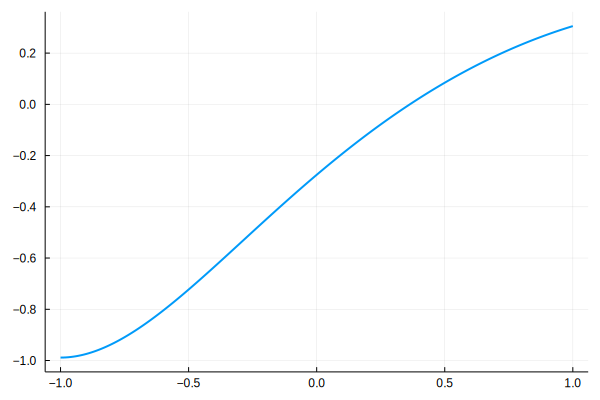

In [8]:
n = 200
h = (b-a)/n
x = [a + i*h for i in 0:n]
Dxx = 1/h^2 * diagm(n+1,n+3,0=>ones(n+1),1=>-2*ones(n+1),2=>ones(n+1))
Dx = 1/2h * diagm(n+1,n+3,0=>-ones(n+1),2=>ones(n+1))
A = Dxx + diagm(p.(x))*Dx + diagm(n+1,n+3,2=>q.(x))
v = f.(x)
ra = [-Ga[2]/2h Ga[1] Ga[2]/2h zeros(1,n)]
rb = [zeros(1,n) -Gb[2]/2h Gb[1] Gb[2]/2h]
A = [ra; A; rb]
v = [⍺; v; β]
i1,i2 = 2:n+2,[1,n+3]
S = A[i1,i2]/A[i2,i2]
ṽ = v[i1] - S*v[i2]
Ã = A[i1,i1] - S*A[i2,i1]
u = Ã\ṽ;

using Plots
plot(x,u,aspect_ratio=1)

The left end does look like a homogeneous Neumann condition is satisfied. We can check the right end numerically using an $O(h)$ discretization.

In [9]:
Gb[1]*u[n+1] + Gb[2]*(u[n+1]-u[n])/h - β

-0.002668110755490005